# Example - markup_images  
> **Model trained On the AM0.1-FLUKE dataset**  
Load the model and run inferences on the test dataset   
**[Run this file online in Colab](https://colab.research.google.com/github/johnnewto/cellsegment/blob/master/nbs/23_example_evaluation_inference.ipynb)**

In [1]:
#hide
# default_exp temp_markup_images
from cellsegment.core import *
from nbdev.showdoc import *

## Setup environment

In [2]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

def in_colab():
    "Check if the code is running in Google Colaboratory"
    try:
        from google import colab
        return True
    except: return False
IN_COLAB = in_colab()

In [3]:
#hide
if IN_COLAB:
    import os
    print('Cloning the cellsegment library')
    os.system('mkdir -p /root/.torch/models')
    os.system('mkdir -p /root/.fastai/data')
    os.system('ln -s /root/.torch/models /content')
    os.system('ln -s /root/.fastai/data /content')
    os.system('rm -rf /content/sample_data/')

### Imports

In [4]:
from cellsegment.core import *
from cellsegment.inference_utils import *
from cellsegment.set_directories import *
import pandas
from fastai.vision import *

### Define directories

In [5]:
local_datapath = '../testdata_2'
# local_datapath = '../../data/FEC/03-M100-Fluke-2019-11/'

dirs = Dirs('data') if IN_COLAB else Dirs(local_datapath)
dirs.model = dirs.model if IN_COLAB else '/home/john/github/data/FEC/03-M100-Fluke-2019-11/models'

print(dirs)

None
  basepath        :  ../testdata_2        
  crop            :  ../testdata_2/Crop-200 
  cropLabel       :  ../testdata_2/Crop-200/Label 
  cropTest        :  ../testdata_2/Crop-200/Test 
  cropTrain       :  ../testdata_2/Crop-200/Train 
  cropValidTxtFile:  ../testdata_2/Crop-200/valid.txt 
  label           :  ../testdata_2/Fullsize/Label 
  model           :  /home/john/github/data/FEC/03-M100-Fluke-2019-11/models 
  originImages    :  ../testdata_2/Original 
  sizeCsvFile     :  ../testdata_2/file_size.csv 
  test            :  ../testdata_2/Fullsize/Test 
  train           :  ../testdata_2/Fullsize/Train 
  validTxtFile    :  ../testdata_2/Fullsize/valid.txt 



### Load the Training Images 
(if in colab)

In [6]:
%%bash
[[ ! -e /tools/google-cloud-sdk ]] &&  exit # if in colab

    export fileid=1SEW0Kf1CI4e4-up4TGsDqwDwVk_QZEUf
    export filename=Fluke-Train-2019-12-01.zip

    ## CURL ##
    curl -L -c cookies.txt 'https://docs.google.com/uc?export=download&id='$fileid \
         | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' > confirm.txt
    curl -L -b cookies.txt -o $filename \
         'https://docs.google.com/uc?export=download&id='$fileid'&confirm='$(<confirm.txt)
    rm -f confirm.txt cookies.txt
    
    unzip -u -q $filename -d data

### Load exported Model

In [7]:
%%bash
[[ ! -e /tools/google-cloud-sdk ]] &&  exit # if in colab
switch=true
if $switch; then  
    export fileid=11cZWhg23QDag_3b7jcd02U8Pzq3W6U5Y
    export filename=export-fluke-2019-12-01.pkl

    ## CURL ##
    curl -L -c cookies.txt 'https://docs.google.com/uc?export=download&id='$fileid \
         | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' > confirm.txt
    curl -L -b cookies.txt -o $filename \
         'https://docs.google.com/uc?export=download&id='$fileid'&confirm='$(<confirm.txt)
    rm -f confirm.txt cookies.txt
fi

## Run model inference on all of the test tiles

In [8]:
path = Path(dirs.crop)
fnames =  get_image_files(path/'Test')

print (f'Number of test tiles {len(fnames)}')

Number of test tiles 13


### Create Learner from exported model

In [9]:
# defaults.device = 'cpu'
defaults.device = 'cuda'
if torch.cuda.is_available():

    def acc_metric1(input, target):
        target = target.squeeze(1)
        return (input.argmax(dim=1)==target).float().mean()

    def acc_metric2(input, target):
        target = target.squeeze(1)
        return (input.argmax(dim=1)[target>0]==target[target>0]).float().mean()

    fn_model = f'{dirs.model}/export-fluke-2019-12-01.pkl'
    learn = load_learner('', fn_model)

    learn.model.float()
    # summary(learn.model, (3, 32, 32))
    print("Learner loaded")
else:
    print("Learner not loaded as torch.cuda.is_available() = ", torch.cuda.is_available())
    

Learner loaded


## utilities

In [35]:
def padImage_t(img, pad=100):
    if pad and pad > 0:
        return F.pad(input=img.px, pad=(pad, pad, pad, pad), mode='constant', value=0)
    else:
        return img

def cut_tiles_t(img, TM=4, TN=4, pad=100):
    M, N = (img.shape[1]-pad*2)//TM, (img.shape[2]-pad*2)//TN 
    OM, ON = pad + M//2, pad + N//2   
    return [Image(img[:,x-OM:x+OM,y-ON:y+ON]) for x in range(pad+M//2,img.shape[1],M) for y in range(pad+N//2,img.shape[2],N)]

def lay_tiles_t(tiles, TM=4, TN=4, pad=100):
    (_,M,N) = tiles[0].size()
    OM, ON = pad + M//2, pad + N//2  
    for n, tile in enumerate(tiles):
        tiles[n] = tile[:,pad:-(pad+1),pad:-(pad+1)]
    
    hstack = [torch.cat(tiles[y:y+TN],dim=2) for y in range(0,TN*TM,TN)]  
    return torch.cat(hstack,dim=1)

def run_prediction(learn, fn, classes=None, filesavedir=None, tile=False, pad=100):
    """
    run predictions and return dictionary of raw predictions
    :param learn: 
    :param fn: 
    :param classes: 
    :param tile: 
    :param pad: 
    :return: 
    """
    img = open_image(fn)
    if tile:
        pad = 100
        TM, TN =2, 2
        img = padImage_t(img, pad=pad)
        tiles = cut_tiles_t(img, TM=TM, TN=TN, pad=pad)
        outputs = [learn.predict(im)[2] for im in tiles]
        raw_pred = lay_tiles_t(outputs, TM=TM, TN=TN, pad=pad)
    else:
        if img.shape[2]%2 == 1:   # make odd dimension make even for unet
           img.px = img.px[:,:,1:] 
        _,_,raw_pred = learn.predict(img)
      
    preds = {c:raw_pred[i,:,:] for i,c in enumerate(classes)}
    if filesavedir:
        for cls,raw_pred in preds.items():
            print(cls, raw_pred.shape)
            # lbl_pil = PIL.Image.fromarray(to_np(raw_pred*255).astype(np.uint8))
            # lbl_pil = lbl_pil.convert('P', palette=PIL.Image.ADAPTIVE, colors=256)
            # lbl_pil.save(f'{filesavedir}/{fn.stem}-{cls}.png')
            save_png_p(to_np(raw_pred), f'{filesavedir}/{fn.stem}-{cls}.png')

    return preds

In [36]:
img_path = Path(dirs.train)
mrk_path = Path('../testdata_2/Fullsize/markup')  
mrk_path.mkdir(parents=True, exist_ok=True)

fnames = sorted(get_image_files(img_path))
classes = ['Background', 'Fluke_Liver', 'Fluke_Rumen', 'Other']

# fnames = fnames[600:]
fnames = fnames[:3]
print(f"Number images to process {len(fnames)}")
preds = run_prediction(learn, fnames[1], classes=classes, tile=False, filesavedir=mrk_path)
preds['Background'].shape
# for fn in fnames:
#     print(fn)
#     pred_img = unet_predict_eggs(fn)
#     PIL.Image.fromarray((pred_img*255).astype(np.uint8)).save(f'{mrk_path}/{fn.stem}.png')  
# show_img(pred_img)


Number images to process 3
Background torch.Size([800, 816])
Fluke_Liver torch.Size([800, 816])
Fluke_Rumen torch.Size([800, 816])
Other torch.Size([800, 816])


torch.Size([800, 816])

In [12]:
## Class Analyse Predictions
# import pdb; pdb.set_trace()
import cv2
from skimage.measure import label, regionprops
from skimage import filters
from skimage.morphology import erosion, dilation, opening, closing, disk
from scipy.spatial import distance
import pandas as pd
from pandas import DataFrame

class AnalysePredictions(object):
    """Methods for preparing and the inference of Well images"""
    def __init__(self):
        """What to do here"""
        self.set_paths();

    def set_paths(self, base_path=None, img_path=None, mrk_path=None):
        if base_path is None:
            base_path = Path().absolute()
        if img_path is not None:
            self.img_path = base_path/Path(img_path) 
            self.mrk_path = base_path/Path(mrk_path)
        else:
            self.img_path = Path('data/images/')
            self.mrk_path = Path('data/markup/')
        
    # NP coder for Tile  into  MxN sections to reduce memory footprint
    def padImage_np(self, img, padding=100):
      if padding and padding > 0:
        return np.stack([np.pad(img[:,:,c], padding, mode='constant', constant_values=0) for c in range(3)], axis=2)
      else:
        return img

    def cut_tiles_np(img, TM=4, TN=4, pad=100):
      M, N = (img.shape[0]-pad*2)//TM, (img.shape[1]-pad*2)//TN 
      OM, ON = pad + M//2, pad + N//2
      return [img[x-OM:x+OM,y-ON:y+ON,:] for x in range(pad+M//2,img.shape[0],M) for y in range(pad+N//2,img.shape[1],N)]

    def lay_tiles_np(self, tiles, TM=4, TN=4, pad=100):
      OM, ON = pad + TM//2, pad + TN//2
      for n, tile in enumerate(tiles):
        tiles[n] = tile[pad:-pad,pad:-pad,:]

      hstack = [np.concatenate(tiles[y:y+TN],axis=1) for y in range(0,TN*TM,TN)]  
      return np.concatenate(hstack,axis=0)

    def test_tile_np(self):
        img = to_np(open_image('data/subset/220972 - 1.jpg').resize(800).px).transpose(1,2,0)
        img = self.padImage_np(img)
        tiles = self.cut_tiles_np(img)
        vstack = self.lay_tiles_np(tiles, TM=4, TN=4, pad=100)
        show_img(vstack, figsize = (10,10))

    ## Tensor coder for Tile  into  MxN sections to reduce memory footprint

    def padImage_t(self, img, pad=100):
      if pad and pad > 0:
        return F.pad(input=img.px, pad=(pad, pad, pad, pad), mode='constant', value=0)
      else:
        return img

    def cut_tiles_t(self, img, TM=4, TN=4, pad=100):
      M, N = (img.shape[1]-pad*2)//TM, (img.shape[2]-pad*2)//TN 
      OM, ON = pad + M//2, pad + N//2  
      return [Image(img[:,x-OM:x+OM,y-ON:y+ON]) for x in range(pad+M//2,img.shape[1],M) for y in range(pad+N//2,img.shape[2],N)]

    def lay_tiles_t(self, tiles, TM=4, TN=4, pad=100):
      (_,M,N) = tiles[0].size()
      OM, ON = pad + M//2, pad + N//2  
      for n, tile in enumerate(tiles):
        tiles[n] = tile[:,pad:-(pad+1),pad:-(pad+1)]

      hstack = [torch.cat(tiles[y:y+TN],dim=2) for y in range(0,TN*TM,TN)]  
      return torch.cat(hstack,dim=1)

    def test_tile_t(self):
        img = open_image('data/subset/220972 - 1.jpg')
        # img = to_np(open_image('data/subset/220972 - 1.jpg').resize(800).px).transpose(1,2,0)
        img = padImage_t(img)
        tiles = cut_tiles_t(img)

        for n, tile in enumerate(tiles):
            tiles[n] = tile.px
            print(tile.px.shape)

        vstack = lay_tiles_t(tiles)
        Image(vstack).show(figsize = (10,10))

    ## Drawing annotation labels on an image
    def draw_labels_cv(self, img, json, radius=40):
      font = cv2.FONT_HERSHEY_SIMPLEX
      for s, sh in enumerate(json['shapes']):
        if sh["label"][:3] == "Str":
          fill = (255,0,0)
        elif sh["label"][:3] == "Nem":
          fill = (0,255,0)
        else:
          print('[Error]: unknown label')

        draw = 'None'  
        if sh['shape_type'] == 'circle':
          draw = 'circle'
          probability = str(sh['probability']) if 'probability' in sh else ''
        elif sh['shape_type'] == 'rectangle':
          draw = 'rectangle'
        else:
          print("Unknown shape_type", sh['shape_type'])


        xy = np.asarray(sh["points"])
        ave = np.mean(xy,axis=0)

        cx = int(ave[0])
        cy = int(ave[1])

        if draw == 'circle':
          cv2.circle(img, (cx, cy), radius, fill, 2)
          cv2.circle(img, (cx, cy), radius, fill, 2)
          cv2.putText(img,probability,(int(cx-radius), cy-radius), font, 1, fill, 2, cv2.LINE_AA)


        elif draw == 'rectangle':
          cv2.rectangle(img, (cx - radius, cy - radius), (cx + radius, cy + radius), fill, 2)

      return img
    def test_draw_labels_cv(self):
        img_path = Path('data/subset/')
        tst_path = Path('data/test/')  
        tst_path.mkdir(parents=True, exist_ok=True)
        fn = Path('data/markup/220966 - 1.png')
        img = np.asarray(PIL.Image.open(fn))
        _json = json.load(open('data/markup/220966 - 1.json'))
        mrk_img = self.draw_labels_cv(img, _json, radius=40) 
        show_img(mrk_img[:500,1000:1500,:], figsize = (10,10))
        PIL.Image.fromarray(mrk_img.astype(np.uint8)).save(f'{tst_path}/{fn.stem}.jpg', quality=90) 

    ## 
    def find_prediction_blobs(self, img, CONF=0.5, radius=40, plot=False): 
        # region props seems to have region.max_intensity errors if no data not np.int 
        SCALE = 100
        CONF *= SCALE
        selem = disk(6)
    #     img = filters.gaussian(img, sigma= 1 / 40, multichannel=True)
        img = (img * (SCALE/img.max())).astype(np.int)
        img[img[:,:,0]<CONF,0] = 0
        img[img[:,:,1]<CONF,1] = 0
    #     img[:,:,0] = img[:,:,0] > CONF
    #     img[:,:,1] = img[:,:,1] > CONF
        predictions = []
    #     imgL = img[:,:,0].astype(np.int)
    #     img[:,:,0] = closing(img[:,:,0], selem)
    #     img[:,:,1] = closing(img[:,:,1], selem)
    #     img[:,:,0] = opening(img[:,:,0], selem)
    #     img[:,:,1] = opening(img[:,:,1], selem)

        fill = (255,0,0)
        label_image0 = label(img[:,:,0] > CONF)
        label_image1 = label(img[:,:,1] > CONF)

#         img = img.copy()  # helped with a cv error?
        img = np.array(img) # helped with a cv error?
        for region in regionprops(label_image0, img[:,:,0], cache=True):
            if region.area > 500:
                cx = int(region.centroid[1])
                cy = int(region.centroid[0])
#                 import pdb; pdb.set_trace()
#                 cv2.rectangle(img, (cx - radius, cy - radius), (cx + radius, cy + radius), fill, 5)
                predictions.append({"label": 'Strongyle', "point": [cx,cy], "probability": region.max_intensity.round(2)})  
    #             print(' 0:', [cx,cy], 'area:',  region.area, 
    #                   'max',  region.max_intensity.round(2), 
    #                   'mean', region.mean_intensity.round(2))
        fill = (0,255,0)
        img = np.array(img) # helped with a cv error?
        for region in regionprops(label_image1, img[:,:,1]):
            if region.area > 500:
                cx = int(region.centroid[1])
                cy = int(region.centroid[0])
#                 cv2.rectangle(img, (cx - radius, cy - radius), (cx + radius, cy + radius), fill, 5)
                predictions.append({"label": 'Nematodirus',"point": [cx,cy], "probability": region.max_intensity.round(2)})
    #             print(f' 1: area {region.area}, max intensity {region.max_intensity.round(5)}')
    #         #     print(region.area)
        if plot:
            #   show_img(imglab, figsize = (15,15))
            plt.figure(figsize=(15, 15))
            plt.subplot(121)
            plt.imshow(label_image0, cmap='nipy_spectral')
            #   plt.imshow(img[:,:,0] > CONF, cmap='nipy_spectral')
            plt.axis('off')
            plt.subplot(122)
            plt.imshow(label_image1, cmap='nipy_spectral')
            plt.axis('off')

            plt.tight_layout()
            plt.show()

        return predictions, img
    def test_find_prediction_blobs(self ): 
    #     fn = 'data/markup/220966 - 1.png'
        tst_path = Path('data/test/')
        fn = Path('data/markup/221221 - 1.png')
        print(f"Testing: def test_find_prediction_blobs('{fn}'):")
        img = np.asarray(PIL.Image.open(fn))


        anno_list, proc_img = self.find_prediction_blobs(img, plot=True)
        print("Max value", proc_img.max())
        PIL.Image.fromarray(proc_img.astype(np.uint8)).save(f'{tst_path}/{fn.stem}.png') 
    #     print(anno_list)

    ## Annotate the json file with predictions
    def annotate_json(self, fn, annotations=None):
        def add_anno(data, item):
            r = 40
            cx,cy = item['point']
            pnt_list = [[cx-r,cy-r], [cx+r,cy+r]]

            probability = str(item['probability']) if 'probability' in item else str(0)

            if item['label'][:3]=='Str': 
                line_color = [255,0,0,127]
                data['shapes'].append({
                        "label": item['label'],"line_color": line_color, "fill_color": None,
                        "points": pnt_list, "shape_type": "circle", 'probability': probability
            })      

            elif item['label'][:3]=='Nem': 
                line_color = [0,255,0,127]
                data['shapes'].append({
                        "label": item['label'],"line_color": line_color, "fill_color": None,
                        "points": pnt_list, "shape_type": "circle", 'probability': probability
                })
            else:
                print('Unknown label')

        def add_annotations(data, annotations): 
            for item in annotations:
                add_anno(data, item)

        def del_circle_annotations(data):
            to_del = [s for s,sh in enumerate(data['shapes']) if sh['shape_type']=='circle']
            if len(to_del) > 0: 
                print(f'Deleting {len(to_del)} circle annotations')
            for i in sorted(to_del, reverse=True):
                del data['shapes'][i]        

        data = json.load(open(fn))
        del_circle_annotations(data)
        add_annotations(data, annotations) 
        return data

    def test_annotate_json(self):  
      fn = 'data/markup/220966 - 1.png'
      img = np.asarray(PIL.Image.open(fn))

      predictions, _ = self.find_prediction_blobs(img, plot=False)
      print(predictions)
      data= self.annotate_json('data/subset/220966 - 1.json', predictions)
      print(data)
      with open('data/subset/220966 - 1.json', 'w') as outfile:
        json.dump(data, outfile, ensure_ascii=False, indent=4)   

    ## Unet Predict classes from a well image
    def unet_predict_classes(self):
        fn = 'data/subset/220967 - 1.json'
        data = json.load(open(fn))

        ## Infer Classes

        img = open_image('data/subset/220972 - 1.jpg')

        img = padImage_t(img)
        tiles = cut_tiles_t(img)

        n = len(tiles)
        pred_class, pred_idx, outputs = [None]*n, [None]*n, [None]*n
        for i, im in enumerate(tiles):
          pc,pi,o = learn.predict(im)  
          pred_class[i] = pc.px

        vstack = lay_tiles_t(pred_class, TM=4, TN=4, pad=100)
        Image(vstack).show(figsize = (10,10))

    ## Infer Probabilities
    def unet_predict_eggs(self, fn):
      img = open_image(fn)

      PAD = 100
      TM, TN =4, 4
      img = padImage_t(img, pad=PAD)
      tiles = cut_tiles_t(img, TM=TM, TN=TN, pad=PAD)

      outputs = []
      for i, im in enumerate(tiles):
        pc,pi,o = learn.predict(im)  
        outputs.append(o)

      vstack = lay_tiles_t(outputs, TM=TM, TN=TN, pad=PAD)
      vstack[0,:,:] = vstack[1,:,:]
      vstack[1,:,:] = vstack[2,:,:]
      vstack[2,:,:] = 0
    #   vstack[vstack<0.3] = 0
      img = to_np(vstack).transpose(1,2,0)
      return img


    ### Generate prediction png file
    # def predict_in_image(self, fn, CONF=0.3):
    #   pred_img = unet_predict_eggs(fn)
    #   predictions = mark_predictions(pred_img, CONF=CONF)
    # #   print(predictions)
    #   jdata= annotate_json(f'{img_path}/{fn.stem}.json', predictions)
    # 
    #   mrk_img = np.asarray(PIL.Image.open(fn))
    #   mrk_img = draw_labels_cv(mrk_img, jdata, radius=50)
    #   return pred_img, mrk_img, jdata

    # def markup_image(self, img, CONF=0.5):
    #     predictions, _ = self.find_prediction_blobs(img, CONF=CONF)
    #     #   print(predictions)
    #     jdata= self.annotate_json(f'{self.img_path}/{fn.stem}.json', predictions)
    # 
    #     mrk_img = np.asarray(PIL.Image.open(f'{img_path}/{fn.stem}.jpg'))
    #     mrk_img = self.draw_labels_cv(mrk_img, jdata, radius=50)
    #     return mrk_img, jdata
    
    def markup_all_images_dir(self, count='all', CONF=0.5):
        fnames = sorted(get_files(self.mrk_path, '.png'))
        if count.isdigit(): 
            fnames = fnames[:count]
        print(f'Marking up {len(fnames)} images')

        for n, fn in enumerate(fnames):
#             print(fn, end=' ')
            src_img = np.asarray(PIL.Image.open(fn))
            # find blobs in png            mrk_img, jdata = self.markup_image(img) 
            predictions, _ = self.find_prediction_blobs(src_img, CONF=CONF)
            print(len(predictions), end=', ')
            if n % 20 == 0:
              print(';')
    
            # annotate json
            jdata= self.annotate_json(f'{self.img_path}/{fn.stem}.json', predictions)
            with open(f'{self.mrk_path}/{fn.stem}.json', 'w') as outfile:
                json.dump(jdata, outfile, ensure_ascii=False, indent=4)   
            # mark up jpg
            mrk_img = np.asarray(PIL.Image.open(f'{self.img_path}/{fn.stem}.jpg'))
            mrk_img = self.draw_labels_cv(mrk_img, jdata, radius=50)
            PIL.Image.fromarray(mrk_img.astype(np.uint8)).save(f'{self.mrk_path}/{fn.stem}.jpg', quality=90)  

        return mrk_img
    


    def calc_stats_row(self, jdata, radius=30):
        human = []
        machine = []
        for s,sh in enumerate(jdata['shapes']):
            ave = np.mean(np.asarray(sh["points"]),axis=0).tolist()
            if sh['shape_type'] == 'rectangle':
                human.append(ave)
            elif sh['shape_type'] == 'circle':
                machine.append(ave)
            else:
                print("unknown label", data["imagePath"])

        if (len(human) > 0) and (len(machine) > 0):
            dist = distance.cdist(human, machine, 'euclidean')
            n_human, n_AI, n_match = len(human), len(machine), (np.min(dist, axis=1) < radius).sum()
        else:
            n_human, n_AI, n_match = len(human), len(machine), 0

        row = {
            'File': jdata["imagePath"],
            'Num Human': n_human, 
            'Num AI': n_AI, 
            'Matched': n_match, 
            'AI: Un-matched': n_AI - n_match, 
            'AI: Missed Eggs': n_human - n_match
        }

        return row

    def calc_stats_table(self):
        # img_path = Path('data/markup')
    #     mrk_path = Path('data/testimages-markup/')

        fnames = sorted(get_files(self.mrk_path, '.json'))

        df = DataFrame (columns = ['File', 'Num Human','Num AI', 'Matched', 'AI: Un-matched', 'AI: Missed Eggs'])
        fnames = fnames
        for fn in fnames:
            data = json.load(open(fn))
            row = self.calc_stats_row(data, radius=30)
            df = df.append(row, ignore_index=True)

        for col in range(1, len(df.columns)):
            df.iloc[:,col] = pd.to_numeric(df.iloc[:,col])

        _sum = df.sum(axis = 0, skipna=True, numeric_only=True).rename('Total') 
        _mean = df.mean(axis = 0, skipna=True, numeric_only=True).rename('Mean') 

        # df= df.append(df.sum(axis = 0, skipna=True, numeric_only=True).rename('Total')) 

        # df=df.append(df.mean(axis = 0, skipna=True, numeric_only=True).rename('Mean'))    
        df = df.append(_mean).append(_sum)
        return df
    def plot_piechart(self, df):
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
        explode = (0.1, 0)  # explode 1st slice
        labels = 'Matched Eggs', 'AI: Missed Eggs' 
        sizes = [df.at['Total','Matched'], df.at['Total','AI: Missed Eggs']]
        axes[0].pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

        labels = 'Matched Eggs', 'AI: Predictions not Matched' 
        sizes = [df.at['Total','Matched'], df.at['Total','AI: Un-matched']]
        axes[1].pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
        plt.tight_layout(pad=0.0)
# pi = AnalysePredictions()
# print("Start tests:")
# pi.test_annotate_json()
# ii.test_draw_labels_cv()
# ii.test_find_prediction_blobs()

### Run Analysis

In [13]:
def find_prediction_blobs( img, CONF=0.3, radius=40, plot=False): 
    # region props seems to have region.max_intensity errors if no data not np.int 
    SCALE = 100
    CONF *= SCALE
    
    img = (img * (SCALE/img.max())).astype(np.int)
    img[img<CONF] = 0
    predictions = []
    label_image = label(img > CONF)
    
    #         img = np.array(img) # helped with a cv error?
    for region in regionprops(label_image, img, cache=True):
        if region.area > 100:
            cx = int(region.centroid[1])
            cy = int(region.centroid[0])
            predictions.append({"label": 'Strongyle', "point": [cx,cy], "probability": region.max_intensity.round(2)})  
    
    return predictions, img


def annotate_json(fn, annotations=None):
    'Annotate the json file with predictions'
    def add_anno(data, item):
        r = 40
        cx,cy = item['point']
        pnt_list = [[cx-r,cy-r], [cx+r,cy+r]]

        probability = str(item['probability']) if 'probability' in item else str(0)

        if item['label'][:3]=='Str': 
            line_color = [255,0,0,127]
            data['shapes'].append({
                    "label": item['label'],"line_color": line_color, "fill_color": None,
                    "points": pnt_list, "shape_type": "circle", 'probability': probability
        })      

        elif item['label'][:3]=='Nem': 
            line_color = [0,255,0,127]
            data['shapes'].append({
                    "label": item['label'],"line_color": line_color, "fill_color": None,
                    "points": pnt_list, "shape_type": "circle", 'probability': probability
            })
        else:
            print('Unknown label')

    def add_annotations(data, annotations): 
        for item in annotations:
            add_anno(data, item)

    def del_circle_annotations(data):
        to_del = [s for s,sh in enumerate(data['shapes']) if sh['shape_type']=='circle']
        if len(to_del) > 0: 
            print(f'Deleting {len(to_del)} circle annotations')
        for i in sorted(to_del, reverse=True):
            del data['shapes'][i]        

    data = json.load(open(fn))
    # del_circle_annotations(data)
    add_annotations(data, annotations) 
    return data

[{'label': 'Strongyle', 'point': [768, 177], 'probability': 69},
 {'label': 'Strongyle', 'point': [313, 336], 'probability': 100},
 {'label': 'Strongyle', 'point': [288, 650], 'probability': 99},
 {'label': 'Strongyle', 'point': [770, 685], 'probability': 83}]

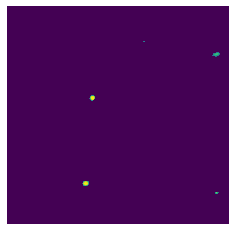

In [14]:
preds
predictions, img = find_prediction_blobs( to_np(preds['Fluke_Liver']))
show_img(img)
predictions

In [15]:
to_np(preds['Fluke_Liver'])

array([[2.530080e-03, 2.290793e-03, 9.769002e-04, 2.425112e-04, ..., 2.832348e-03, 4.224682e-03, 4.696379e-03,
        8.341388e-03],
       [7.502590e-04, 8.338390e-04, 7.248910e-04, 1.502040e-04, ..., 2.461558e-03, 4.082000e-03, 4.715894e-03,
        6.574791e-03],
       [3.527227e-04, 3.848545e-04, 6.420778e-04, 1.822658e-04, ..., 2.942182e-03, 5.112409e-03, 4.840271e-03,
        2.247877e-03],
       [2.976774e-04, 3.085131e-04, 5.771366e-04, 2.293458e-04, ..., 1.864430e-03, 3.432195e-03, 2.624897e-03,
        7.026473e-04],
       ...,
       [1.984489e-03, 2.766282e-03, 1.858092e-03, 5.149026e-04, ..., 2.815052e-07, 9.348914e-07, 2.402427e-06,
        2.821103e-06],
       [3.302467e-03, 3.153032e-03, 2.695337e-03, 1.164194e-03, ..., 3.090470e-06, 7.436967e-06, 1.892944e-05,
        2.077264e-05],
       [1.551290e-03, 7.544339e-04, 1.294823e-03, 6.098641e-04, ..., 5.507753e-06, 1.009877e-05, 1.959550e-05,
        5.298379e-05],
       [1.568920e-03, 7.218754e-04, 1.271034e-03, 

In [22]:
img_path = Path(dirs.train)
mrk_path = Path('../testdata_2/Fullsize/markup')  
mrk_path.mkdir(parents=True, exist_ok=True)

fnames = sorted(get_image_files(img_path))
classes = ['Background', 'Fluke_Liver', 'Fluke_Rumen', 'Other']

preds = run_prediction(learn, fnames[1], classes=classes, tile=False, filesavedir=mrk_path)

Background torch.Size([800, 816])
Fluke_Liver torch.Size([800, 816])
Fluke_Rumen torch.Size([800, 816])
Other torch.Size([800, 816])


In [21]:
def save_png(img:np.ndarray, fn, cmap:str='hot'):
    # img = PIL.Image.fromarray(to_np(img*255).astype(np.uint8))
    # img = img.convert('P', palette=PIL.Image.ADAPTIVE, colors=256)
    # img.save(fn)
    # Get the color map by name:
    cm = plt.get_cmap(cmap)
    colored_image = cm(img)
    PIL.Image.fromarray((colored_image * 255).astype(np.uint8)).save(fn)   

def save_png_p(img:np.ndarray, fn, cmap:str='hot', num_colors=256):
    assert num_colors > 0 and num_colors <= 256, 'num_colors must be in range 0 to 256'
    cm = plt.get_cmap(cmap)
    palette = np.ones((256,3),dtype=np.uint8)*128
    pal = (cm(np.arange(num_colors))*255).astype(np.uint8)[:,:3]
    palette[:num_colors,:] = pal
    img = PIL.Image.fromarray((img*255).astype(np.uint8), mode='P')
    img.putpalette(palette)
    img.save(fn)

raw_pred  = to_np(preds['Fluke_Liver'])
save_png_p(raw_pred, f'{mrk_path}/{"111test"}.png', cmap='tab10', num_colors=10)
save_png_p(raw_pred, f'{mrk_path}/{"112test"}.png')
save_png_p(raw_pred, f'{mrk_path}/{"113test"}.png', cmap='Dark2', num_colors=8)

In [ ]:
palette = np.arange(256)
cm = plt.get_cmap('hot')
palette = (cm(np.arange(256))*255).astype(np.uint8)[:,:3]
palette

[colormaps](https://matplotlib.org/2.0.1/examples/color/colormaps_reference.html)

In [ ]:
#
raw_pred  = preds['Fluke_Liver']
save_png(raw_pred, f'{mrk_path}/{"111test"}.png')

In [ ]:
mrk_path

In [ ]:
seq = np.arange(256)
cm = plt.get_cmap('hot')
AAcolored_image = cm(seq)

In [ ]:
palette = np.arange(10)
cm = plt.get_cmap('tab10')
palette = (cm(np.arange(10))*255).astype(np.uint8)[:,:3]
palette